In [2]:
import os
import warnings

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.errors import ParserWarning

warnings.simplefilter(action='ignore', category=ParserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

import utils.data as datutils

In [3]:
m14 = pd.read_csv('data/gadgetx3k_20/mag_diff_GadgetX_3k.txt', sep=r'\s+')
display(m14)

,3d,proj_x,proj_y,proj_z
0,1.009199,1.009199,1.009199,1.009199
1,0.095047,0.095047,0.095047,0.095047
2,1.098583,1.098583,1.098583,1.098583
3,1.631226,1.631226,1.631226,1.631226
4,0.068340,0.068340,0.068340,0.068340
...,...,...,...,...
319,3.705206,3.705206,3.705206,3.705206
320,1.295134,1.295134,1.295134,1.295134
321,1.950024,1.950024,1.950024,1.950024
322,2.547174,1.644009,2.440292,2.547174


In [8]:
mah_df_list = []
dir = 'data/gadgetx3k_20/AHF_History/'
for f in os.listdir(dir):
    file = dir + f
    mm0 = datutils.load_mah(file)
    mah_df_list.append(mm0)

In [ ]:
corrs_list = []
z_list = []
mah_gap_dict = {}
for z in mah_df_list[0]['Redshift']:
    mah_df = pd.DataFrame(columns=['M/M0'])

    for region in range(20):
        row = mah_df_list[region].loc[mah_df_list[region]
                                      ['Redshift'] == z, ['M/M0']]
        if not row.empty:
            mah_df = pd.concat([mah_df, row], ignore_index=True)

    if mah_df.shape[0] != m14[:20].shape[0]:
        # print(
        #     f"Skipping redshift {z}: mismatched rows {mah_df.shape[0]} vs {m14[:20].shape[0]}")
        continue

    df = pd.concat([mah_df.reset_index(drop=True),
                   m14[:20].reset_index(drop=True)], axis=1)
    mah_gap_dict[z] = df
    corrs = df.corr(method='spearman')
    corrs_list.append(corrs)
    z_list.append(z)

z_array = np.array(z_list)
aexp = 1/(1+z_array)

Skipping redshift 0.021: mismatched rows 19 vs 20
Skipping redshift 0.044: mismatched rows 19 vs 20
Skipping redshift 0.167: mismatched rows 19 vs 20
Skipping redshift 0.193: mismatched rows 18 vs 20
Skipping redshift 0.22: mismatched rows 18 vs 20
Skipping redshift 0.247: mismatched rows 19 vs 20
Skipping redshift 0.858: mismatched rows 19 vs 20
Skipping redshift 1.269: mismatched rows 19 vs 20
Skipping redshift 1.369: mismatched rows 3 vs 20
Skipping redshift 1.477: mismatched rows 5 vs 20
Skipping redshift 1.589: mismatched rows 7 vs 20
Skipping redshift 1.644: mismatched rows 7 vs 20
Skipping redshift 1.765: mismatched rows 12 vs 20
Skipping redshift 1.89: mismatched rows 14 vs 20
Skipping redshift 2.021: mismatched rows 18 vs 20
Skipping redshift 2.159: mismatched rows 19 vs 20
Skipping redshift 3.3: mismatched rows 1 vs 20
Skipping redshift 3.591: mismatched rows 5 vs 20
Skipping redshift 3.7: mismatched rows 5 vs 20
Skipping redshift 4.018: mismatched rows 10 vs 20
Skipping reds

In [16]:
gap_3d = [df.loc['3d', 'M/M0'] for df in corrs_list]
gap_x = [df.loc['proj_x', 'M/M0'] for df in corrs_list]
gap_y = [df.loc['proj_y', 'M/M0'] for df in corrs_list]
gap_z = [df.loc['proj_z', 'M/M0'] for df in corrs_list]

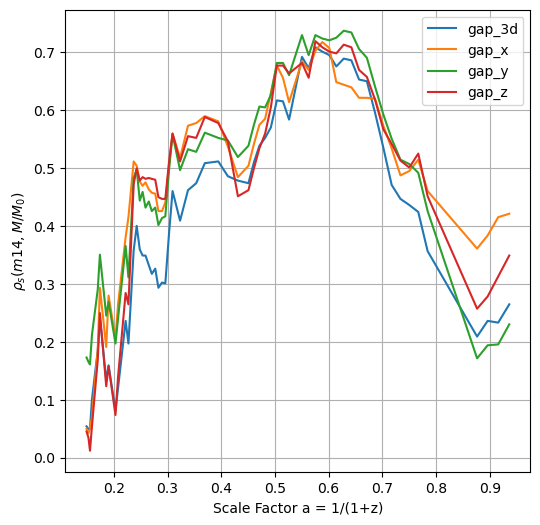

In [29]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
axs.plot(aexp, gap_3d, label='gap_3d')
axs.plot(aexp, gap_x, label='gap_x')
axs.plot(aexp, gap_y, label='gap_y')
axs.plot(aexp, gap_z, label='gap_z')
axs.set_xlabel('Scale Factor a = 1/(1+z)')
axs.set_ylabel(r'$\rho_s (m14, M/M_0)$')
axs.grid()
plt.legend()
plt.show()

In [22]:
size = 100
mm0 = np.linspace(1e-5, 1, size)      # set up mah array
mm0_dict = {}
for m in mm0:
    # create dataframe for each mm0 value
    mm0_dict[m] = pd.DataFrame(columns=['aexp'])

In [23]:
tol = 1e-2
for mah in mah_df_list:
    # For each row in each mah snap, if it is close to an mm0 value then go to
    # dataframe at corresponding mm0_dict key and add the row(s) to that df.
    # In the end, for each mm0 value there is a df of aexp values.
    for m in mm0:
        err = np.abs((mah['M/M0'] - m))
        mask = err < tol
        mm0_dict[m] = pd.concat([mm0_dict[m], mah['aexp'][mask]])

In [24]:
# now we assemble the dictionary of ds+aexp params
# each key is an mm0 val, each val is the joint df
m14_aexp_dict = {}
for k, df in mm0_dict.items():
   if len(df) > len(m14):
      df1 = df.sample(len(m14))
      df2 = m14
   else:
      df1 = df
      df2 = m14.sample(len(m14))
   m14_aexp_dict[k] = pd.concat([df2.reset_index(drop=True),
                                df1.reset_index(drop=True)], axis=1)

In [ ]:
m14_aexp_corrs = {}
for k, v in m14_aexp_dict.items():
    m14_aexp_corrs[k] = v.corr(method='spearman')

In [27]:
gap3d = [df.loc['3d', 'aexp'] for _, df in m14_aexp_corrs.items()]
gapx = [df.loc['proj_x', 'aexp'] for _, df in m14_aexp_corrs.items()]
gapy = [df.loc['proj_y', 'aexp'] for _, df in m14_aexp_corrs.items()]
gapz = [df.loc['proj_z', 'aexp'] for _, df in m14_aexp_corrs.items()]

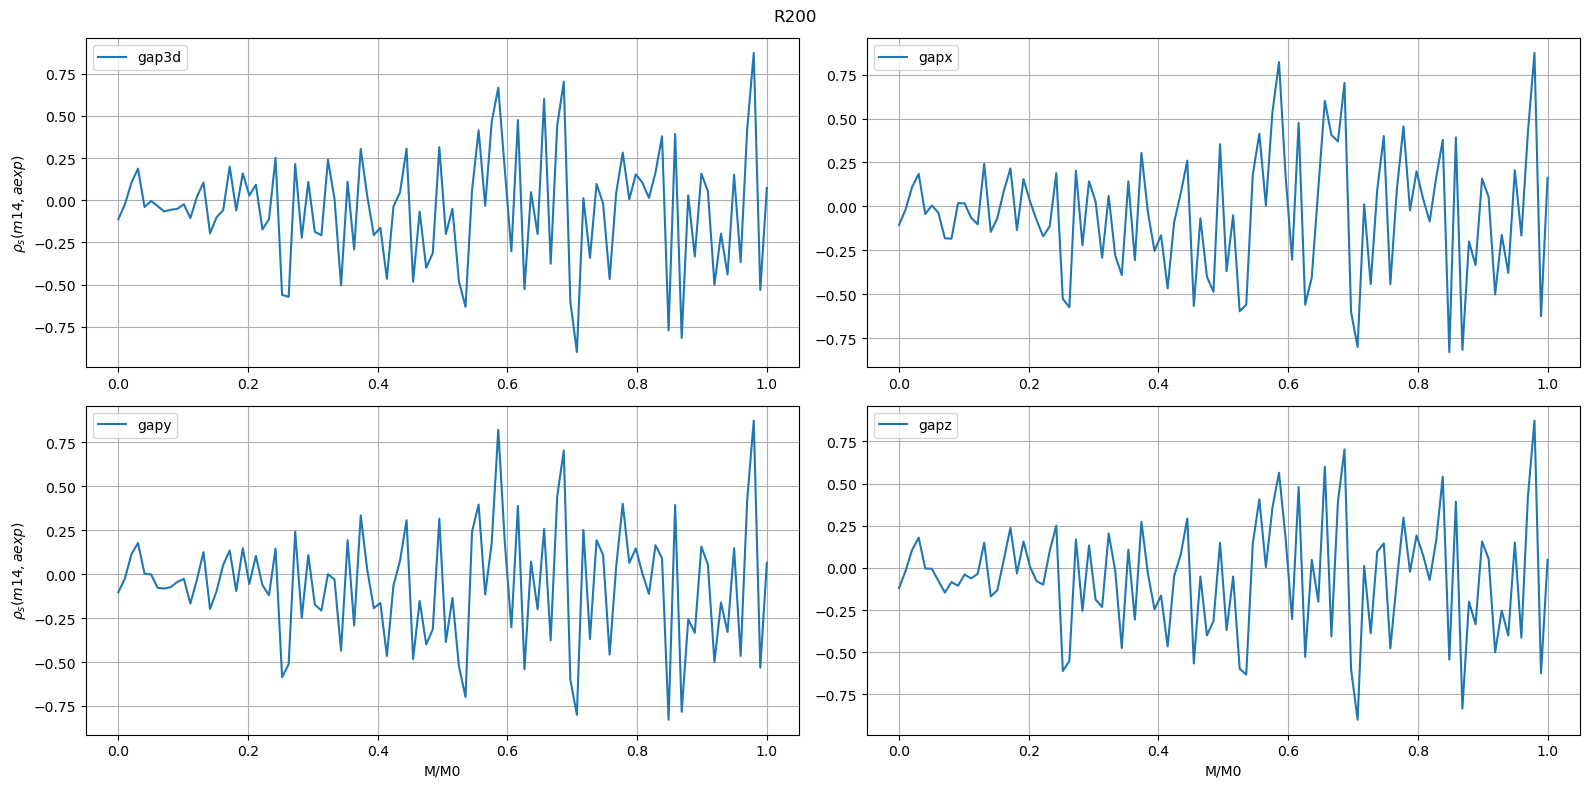

In [28]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
fig.suptitle('R200')

axs[0, 0].plot(mm0, gap3d, label='gap3d')
axs[0, 0].grid()
axs[0, 0].legend()

axs[0, 1].plot(mm0, gapx, label='gapx')
axs[0, 1].grid()
axs[0, 1].legend()

axs[1, 0].plot(mm0, gapy, label='gapy')
axs[1, 0].grid()
axs[1, 0].legend()

axs[1, 1].plot(mm0, gapz, label='gapz')
axs[1, 1].grid()
axs[1, 1].legend()

axs[1, 0].set_xlabel('M/M0')
axs[1, 1].set_xlabel('M/M0')
axs[0, 0].set_ylabel(r'$\rho_s (m14,aexp)$')
axs[1, 0].set_ylabel(r'$\rho_s (m14,aexp)$')

plt.tight_layout()
plt.legend()
plt.show()

In [5]:
dsdf_list = []
m14_ds_list = []
for file in sorted(os.listdir('data/gadgetx3k_20/G3X_progenitors/')):
    ds_file = 'data/gadgetx3k_20/G3X_progenitors/' + file
    ds_df = pd.read_csv(ds_file, sep=r'\s+', index_col=False)
    dsdf_list.append(ds_df)
    m14_ds = pd.concat([m14.reset_index(drop=True), 
                        ds_df.reset_index(drop=True)])
    m14_ds_list.append(m14_ds)

In [6]:
corr_list = []
for df in m14_ds_list:
    corr = df.corr(method='spearman')
    corr_list.append(corr)

In [7]:
redshift_list = pd.read_csv('data/gadgetx3k_20/redshift_list.txt', sep=r'\s+')
redshift_list[32:]  # DS files start at snap 32

,n,z,a
32,32,7.38900,0.1192
33,33,7.20300,0.1219
34,34,7.02600,0.1246
35,35,6.84900,0.1274
36,36,6.67500,0.1303
...,...,...,...
124,124,0.09266,0.9152
125,125,0.06872,0.9357
126,126,0.04526,0.9567
127,127,0.02239,0.9781


In [11]:
corr_list[10]

,3d,proj_x,proj_y,proj_z,rID[0],Hid[1],DS_200[2],eta_200[3],delta_200[4],fm_200[5],fm2_200[6],DS_500[7],eta_500[8],delta_500[9],fm_500[10],fm2_500[11]
3d,1.000000,0.941849,0.965938,0.967984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
proj_x,0.941849,1.000000,0.920104,0.946261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
proj_y,0.965938,0.920104,1.000000,0.938762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
proj_z,0.967984,0.946261,0.938762,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rID[0],NaN,NaN,NaN,NaN,1.000000,-0.071903,-0.011693,-0.058144,-0.071813,-0.041935,-0.031782,0.006037,-0.077957,-0.098827,-0.057683,-0.053410
Hid[1],NaN,NaN,NaN,NaN,-0.071903,1.000000,0.070059,-0.237373,0.452984,-0.400702,-0.360142,0.060024,-0.309871,0.471233,-0.398416,-0.385694
DS_200[2],NaN,NaN,NaN,NaN,-0.011693,0.070059,1.000000,0.113901,-0.260770,-0.064026,-0.059959,0.573804,0.149127,-0.169360,-0.024621,-0.020276
eta_200[3],NaN,NaN,NaN,NaN,-0.058144,-0.237373,0.113901,1.000000,0.051565,0.230396,0.200673,0.113491,0.685065,0.167768,0.390362,0.377762
delta_200[4],NaN,NaN,NaN,NaN,-0.071813,0.452984,-0.260770,0.051565,1.000000,0.224174,0.234960,-0.045837,0.004649,0.802575,0.033032,0.030813
fm_200[5],NaN,NaN,NaN,NaN,-0.041935,-0.400702,-0.064026,0.230396,0.224174,1.000000,0.989052,0.058500,0.291636,0.090950,0.657684,0.651196


In [8]:
d3_delta200 = [df.loc['delta_200[4]', '3d'] for df in corr_list]
d3_fm200 = [df.loc['fm_200[5]', '3d'] for df in corr_list]
d3_fm2200 = [df.loc['fm2_200[6]', '3d'] for df in corr_list]

eta_delta500 = [df.loc['delta_500[9]', 'eta_500[8]'] for df in corr_list]
eta_fm500 = [df.loc['fm_500[10]', 'eta_500[8]'] for df in corr_list]
eta_fm2500 = [df.loc['fm2_500[11]', 'eta_500[8]'] for df in corr_list]

delta_eta200 = [df.loc['eta_200[3]', 'delta_200[4]'] for df in corr_list]
delta_fm200 = [df.loc['fm_200[5]', 'delta_200[4]'] for df in corr_list]
delta_fm2200 = [df.loc['fm2_200[6]', 'delta_200[4]'] for df in corr_list]

delta_eta500 = [df.loc['eta_500[8]', 'delta_500[9]'] for df in corr_list]
delta_fm500 = [df.loc['fm_500[10]', 'delta_500[9]'] for df in corr_list]
delta_fm2500 = [df.loc['fm2_500[11]', 'delta_500[9]'] for df in corr_list]

fm_eta200 = [df.loc['eta_200[3]', 'fm_200[5]'] for df in corr_list]
fm_delta200 = [df.loc['delta_200[4]', 'fm_200[5]'] for df in corr_list]
fm_fm2200 = [df.loc['fm2_200[6]', 'fm_200[5]'] for df in corr_list]

fm_eta500 = [df.loc['eta_500[8]', 'fm_500[10]'] for df in corr_list]
fm_delta500 = [df.loc['delta_500[9]', 'fm_500[10]'] for df in corr_list]
fm_fm2500 = [df.loc['fm2_500[11]', 'fm_500[10]'] for df in corr_list]

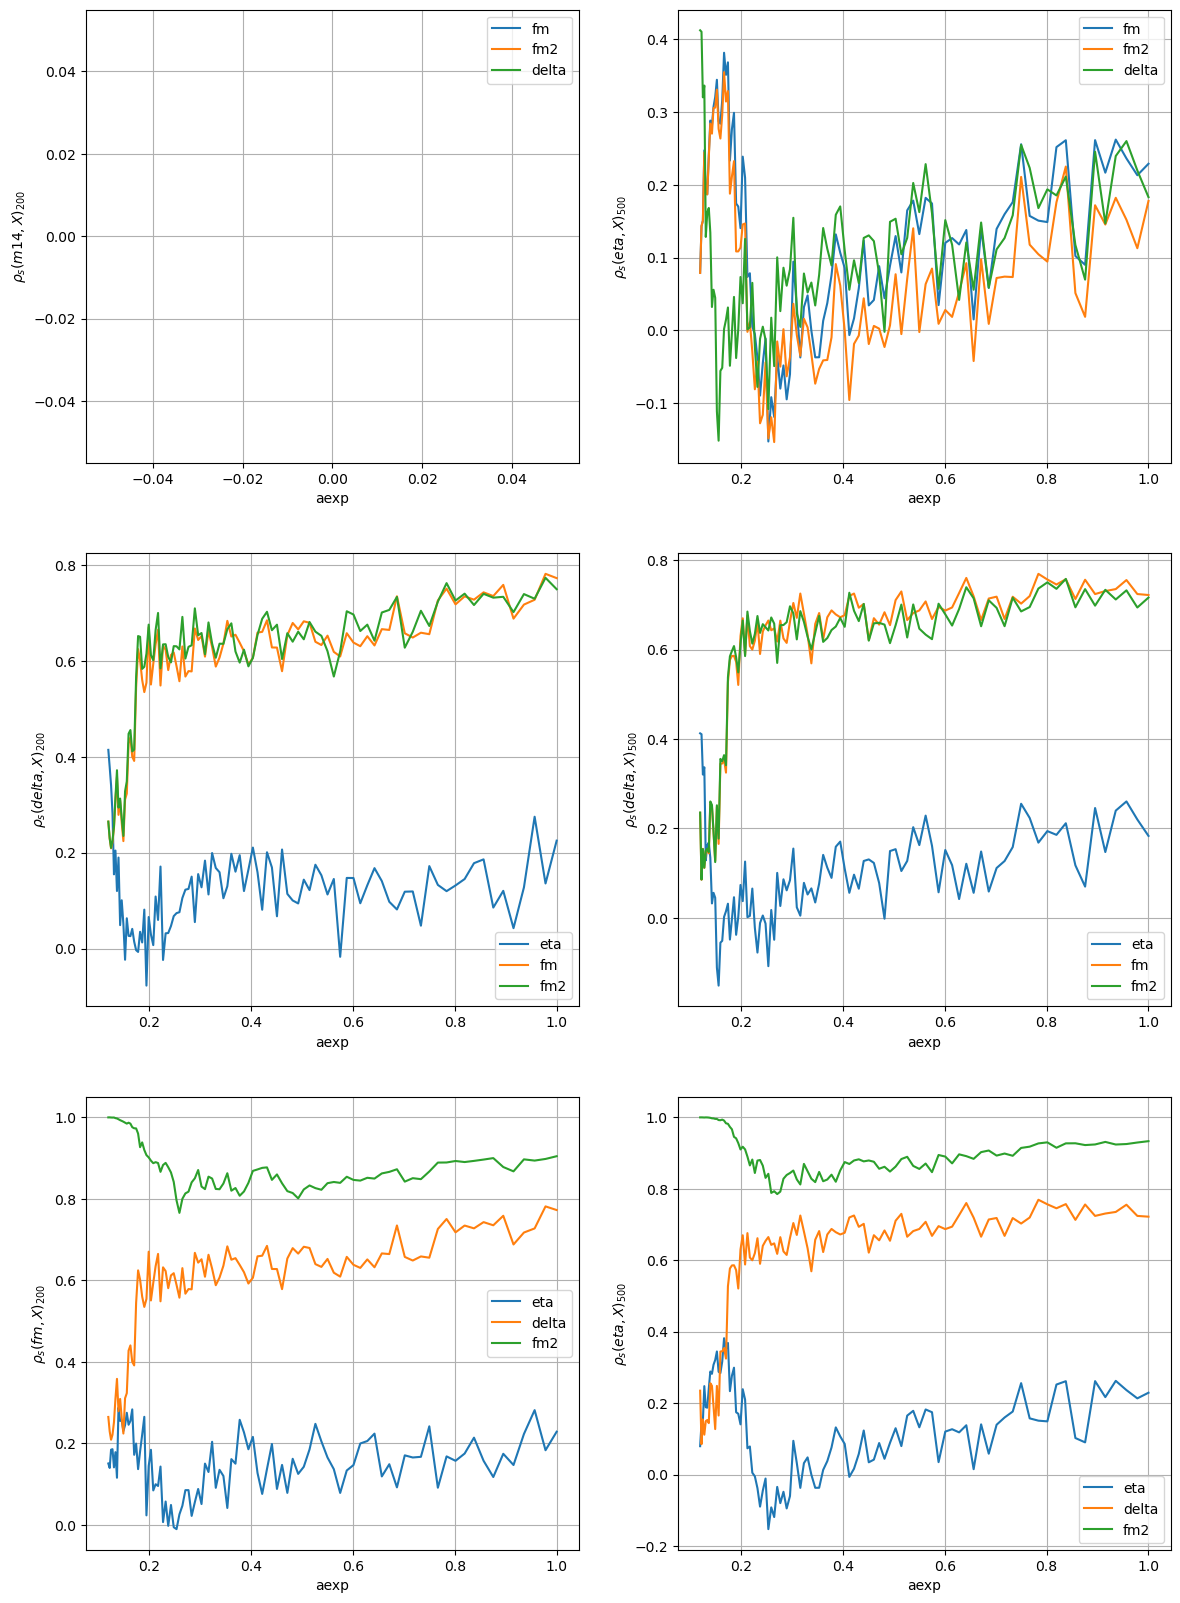

In [9]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(14, 20))

axs[0][0].plot(redshift_list[32:]['a'], d3_fm2200, label='fm')
axs[0][0].plot(redshift_list[32:]['a'], d3_fm200, label='fm2')
axs[0][0].plot(redshift_list[32:]['a'], d3_delta200, label='delta')
axs[0][0].set_ylabel(r'$\rho_s (m14, X)_{200}$')
axs[0][0].set_xlabel('aexp')
axs[0][0].grid()
axs[0][0].legend()

axs[0][1].plot(redshift_list[32:]['a'], eta_fm500, label='fm')
axs[0][1].plot(redshift_list[32:]['a'], eta_fm2500, label='fm2')
axs[0][1].plot(redshift_list[32:]['a'], eta_delta500, label='delta')
axs[0][1].set_ylabel(r'$\rho_s (eta, X)_{500}$')
axs[0][1].set_xlabel('aexp')
axs[0][1].grid()
axs[0][1].legend()

axs[1][0].plot(redshift_list[32:]['a'], delta_eta200, label='eta')
axs[1][0].plot(redshift_list[32:]['a'], delta_fm200, label='fm')
axs[1][0].plot(redshift_list[32:]['a'], delta_fm2200, label='fm2')
axs[1][0].set_ylabel(r'$\rho_s (delta, X)_{200}$')
axs[1][0].set_xlabel('aexp')
axs[1][0].grid()
axs[1][0].legend()

axs[1][1].plot(redshift_list[32:]['a'], delta_eta500, label='eta')
axs[1][1].plot(redshift_list[32:]['a'], delta_fm500, label='fm')
axs[1][1].plot(redshift_list[32:]['a'], delta_fm2500, label='fm2')
axs[1][1].set_ylabel(r'$\rho_s (delta, X)_{500}$')
axs[1][1].set_xlabel('aexp')
axs[1][1].grid()
axs[1][1].legend()

axs[2][0].plot(redshift_list[32:]['a'], fm_eta200, label='eta')
axs[2][0].plot(redshift_list[32:]['a'], fm_delta200, label='delta')
axs[2][0].plot(redshift_list[32:]['a'], fm_fm2200, label='fm2')
axs[2][0].set_ylabel(r'$\rho_s (fm, X)_{200}$')
axs[2][0].set_xlabel('aexp')
axs[2][0].grid()
axs[2][0].legend()

axs[2][1].plot(redshift_list[32:]['a'], fm_eta500, label='eta')
axs[2][1].plot(redshift_list[32:]['a'], fm_delta500, label='delta')
axs[2][1].plot(redshift_list[32:]['a'], fm_fm2500, label='fm2')
axs[2][1].set_ylabel(r'$\rho_s (eta, X)_{500}$')
axs[2][1].set_xlabel('aexp')
axs[2][1].grid()
axs[2][1].legend()

plt.legend()
plt.show()